# PHYS 3317 -- Finite Differences in 2D

<em> Lee Swindell </em>

### Utilities

In [1]:
%pylab inline
from __future__ import division  #get rid of integer division bug

Populating the interactive namespace from numpy and matplotlib


In [2]:
from showmat import showmat #import function for printing matrices

### Formalism

We want to make a finite difference approximation to the 2D Laplacian

$$\nabla^2 \psi(x,y)= \frac{1}{\delta^2}\left[\psi(x+\delta,y)+\psi(x-\delta,y)+\psi(x,y+\delta)+\psi(x,y-\delta)-4\psi(x,y)\right]$$

The most natural representation would be as a rank 4 tensor.  That is if we define

$$\phi=\nabla^2\psi$$

Then $\phi(x,y)$ is some linear combination of $\psi(x^\prime,y^\prime)$.  Unfortunately, most software packages do not deal well with rank 4 tensors.  [For example, you can not use off-the-shelf algorithms to get their Eigenvalues.]

One approach is to number the points on our 2D grid, and think of it as a 1D list.  For example, imagine we have a $3\times 3$ grid:

In [3]:
mesh=arange(9,dtype=integer).reshape(3,3)
mesh

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

These numbers will label the points so that

$$ \begin{array}{c}
\psi_0=\psi(x=0,y=0)\cr \psi_1=\psi(x=1,y=0)\cr \psi_2=\psi(x=2,y=0)\cr \psi_3=\psi(x=0,y=1)\cr
\psi_4=\psi(x=1,y=1)\cr
\psi_5=\psi(x=2,y=1)\cr
\psi_6=\psi(x=0,y=2)\cr
\psi_7=\psi(x=1,y=2)\cr
\psi_8=\psi(x=2,y=2)
\end{array}$$

We need a function which takes a vector $\psi_1,\psi_2,\cdots$ and rearanges them into the right geometric order

In [4]:
def twodrep(vec):
    """ twodrep reshapes a linear array into a square array"""
    size=sqrt(len(vec)) # How many psi's do we have
    ans=vec.copy() # So as not to cause any nasty side-effects, lets copy the array
    return ans.reshape(size,size) # reshape

In [5]:
test=array((0,0,0,0,1,0,0,0,0)) # sample array of 9 elements

In [6]:
testarray=twodrep(test)  # wrap it into a square
testarray                # display the result

array([[0, 0, 0],
       [0, 1, 0],
       [0, 0, 0]])

In [7]:
showmat(testarray)  # here is a fancy display function 

,,
,1,
,,


### Generating The Laplacian

We now generate the laplacian -- here I will take dx=1, but we can scale it later.  First lets just make an empty matrix

In [8]:
laplacematrix=zeros((9,9))
showmat(laplacematrix)

,,,,,,,,
,,,,,,,,
,,,,,,,,
,,,,,,,,
,,,,,,,,
,,,,,,,,
,,,,,,,,
,,,,,,,,
,,,,,,,,


Now lets set the diagonal elements.  We will use some cool notation

In [18]:
# set diagonal elements
laplacematrix[mesh,mesh]=-4
showmat(laplacematrix)

-4,1,,1,,,,,
1,-4,1,,1,,,,
,1,-4,,,1,,,
1,,,-4,1,,1,,
,1,,1,-4,1,,1,
,,1,,1,-4,,,1
,,,1,,,-4,1,
,,,,1,,1,-4,1
,,,,,1,,1,-4


Next let us set all of the shifted one-to-the right elements.  Since we can't hop to the right from the rightmost elements (unless we use periodic boundary conditions) we need to generate a matrix which has the last column of mesh removed

In [10]:
left=mesh[:,:-1]
left

array([[0, 1],
       [3, 4],
       [6, 7]])

You might want to play with this notation a bit -- its really cool. [Click here for some array tips](http://pages.physics.cornell.edu/~myers/teaching/ComputationalMethods/python/arrays.html) 

We do the same thing with the right

In [11]:
right=mesh[:,1:]
right

array([[1, 2],
       [4, 5],
       [7, 8]])

setting the hopping right terms is then easy

In [12]:
laplacematrix[[left,right]]=1
showmat(laplacematrix)

-4,1,,,,,,,
,-4,1,,,,,,
,,-4,,,,,,
,,,-4,1,,,,
,,,,-4,1,,,
,,,,,-4,,,
,,,,,,-4,1,
,,,,,,,-4,1
,,,,,,,,-4


<b> Problem:</b> In our 1D example of finite difference, all of the entries one from the diagonal were set to 1.  This one has some zeros.  Why?

<em> the zeros are when we are encountering the boundary of one of the vectors. Since this is two dimensional, we encounter the boundary of one dimension and then keep hitting it when finding the other dimension.  </em>

hopping left is just

In [13]:
laplacematrix[[right,left]]=1
showmat(laplacematrix)

-4,1,,,,,,,
1,-4,1,,,,,,
,1,-4,,,,,,
,,,-4,1,,,,
,,,1,-4,1,,,
,,,,1,-4,,,
,,,,,,-4,1,
,,,,,,1,-4,1
,,,,,,,1,-4


The 3x3 blocks which correspond to individual rows should be clear

<b> Problem:</b> Write code to add the hopping up and down terms to laplacematrix

In [19]:
up=mesh[1:,:]
down=mesh[:-1,:]
laplacematrix[[down,up]]=1
laplacematrix[[up,down]]=1
showmat(laplacematrix)

-4,1,,1,,,,,
1,-4,1,,1,,,,
,1,-4,,,1,,,
1,,,-4,1,,1,,
,1,,1,-4,1,,1,
,,1,,1,-4,,,1
,,,1,,,-4,1,
,,,,1,,1,-4,1
,,,,,1,,1,-4


<b> Problem:</b>Test your code by seeing what it does to our test vector

In [20]:
showmat(twodrep(laplacematrix.dot(test)))

,1,
1,-4,1
,1,


### Now with Sparse Arrays

We can be more efficient if we use sparse arrays so that we don't store all of those zeros

In [21]:
from scipy.sparse import *  # loads the required functions

We will use the "dictionary of keys" form of a sparse matrix.  [For our 1D arrays we used the dia_matrix format for this, but I find the dok syntax more transparent for this applications.  There is a slight numerical efficiency gained by using dia_matrix, but this is more than offset by the ease of construction.]

In [22]:
dok_matrix?

In [23]:
sparselaplace=dok_matrix((9,9))
sparselaplace

<9x9 sparse matrix of type '<type 'numpy.float64'>'
	with 0 stored elements in Dictionary Of Keys format>

In [24]:
showmat(sparselaplace.todense())

,,,,,,,,
,,,,,,,,
,,,,,,,,
,,,,,,,,
,,,,,,,,
,,,,,,,,
,,,,,,,,
,,,,,,,,
,,,,,,,,


Unfortunately our old notation does not quite work

In [25]:
sparselaplace[mesh,mesh]=-4

In [26]:
showmat(sparselaplace.todense())

-4,,,,,,,,
,-4,,,,,,,
,,-4,,,,,,
,,,-4,,,,,
,,,,-4,,,,
,,,,,-4,,,
,,,,,,-4,,
,,,,,,,-4,
,,,,,,,,-4


Lets start over

In [27]:
sparselaplace=dok_matrix((9,9))
sparselaplace

<9x9 sparse matrix of type '<type 'numpy.float64'>'
	with 0 stored elements in Dictionary Of Keys format>

First we make a linear list of the elements we want to set

In [28]:
elements=zip(mesh.flatten(),mesh.flatten()) 
elements

[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8)]

Then we loop over these

In [29]:
for key in elements:
    sparselaplace[key]=-4
showmat(sparselaplace.todense())

-4,,,,,,,,
,-4,,,,,,,
,,-4,,,,,,
,,,-4,,,,,
,,,,-4,,,,
,,,,,-4,,,
,,,,,,-4,,
,,,,,,,-4,
,,,,,,,,-4


We can do a similar procedure with the hopping right

In [30]:
elements=zip(left.flatten(),right.flatten())
elements

[(0, 1), (1, 2), (3, 4), (4, 5), (6, 7), (7, 8)]

In [31]:
for key in elements:
    sparselaplace[key]=1
showmat(sparselaplace.todense())

-4,1,,,,,,,
,-4,1,,,,,,
,,-4,,,,,,
,,,-4,1,,,,
,,,,-4,1,,,
,,,,,-4,,,
,,,,,,-4,1,
,,,,,,,-4,1
,,,,,,,,-4


<b> Problem:</b> Repeat for the hopping right, up and down.

In [34]:
elements1=zip(right.flatten(),left.flatten())
for key in elements1:
    sparselaplace[key]=1
elements2=zip(up.flatten(),down.flatten())
for key in elements2:
    sparselaplace[key]=1
elements3=zip(down.flatten(),up.flatten())
for key in elements3:
    sparselaplace[key]=1
    
showmat(sparselaplace.todense())


-4,1,,1,,,,,
1,-4,1,,1,,,,
,1,-4,,,1,,,
1,,,-4,1,,1,,
,1,,1,-4,1,,1,
,,1,,1,-4,,,1
,,,1,,,-4,1,
,,,,1,,1,-4,1
,,,,,1,,1,-4


Now lets encapsulate this into a function

In [50]:
def makelaplacematrix(numgridpoints,dx):
    """makelaplacematrix(numgridpoints,dx) returns a (numgridpoints^2)x(numgridpoints^2) square matrix
    which represents the laplacian on the 2d grid with grid spacing dx.  It is in the dok_matrix format,
    and has hard wall boundary conditions"""
    
    mat=dok_matrix((numgridpoints**2,numgridpoints**2))
    mesh=arange(0,numgridpoints**2,dtype=integer).reshape(numgridpoints,numgridpoints)
    elements=zip(mesh.flatten(),mesh.flatten())
    left=mesh[:,:-1]
    right=mesh[:,1:]
    up=mesh[1:,:]
    down=mesh[:-1,:]
    elements1=zip(left.flatten(),right.flatten())
    elements2=zip(right.flatten(),left.flatten())
    elements3=zip(up.flatten(),down.flatten())
    elements4=zip(down.flatten(),up.flatten())
    for key in elements:
        mat[key]=-4/(dx**2)
    for key in elements1:
        mat[key]=1/(dx**2)
    for key in elements2:
        mat[key]=1/(dx**2)
    for key in elements3:
        mat[key]=1/(dx**2)
    for key in elements4:
        mat[key]=1/(dx**2)
    
    return mat 

Test with the following code:  you should get -400 on the diagonal, and 100's in a few other places

In [51]:
lmat=makelaplacematrix(10,0.1)
showmat(lmat.todense())

-400,100,,,,,,,,,100,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100,-400,100,,,,,,,,,100,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,100,-400,100,,,,,,,,,100,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,100,-400,100,,,,,,,,,100,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,100,-400,100,,,,,,,,,100,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,100,-400,100,,,,,,,,,100,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,100,-400,100,,,,,,,,,100,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,100,-400,100,,,,,,,,,100,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,100,-400,100,,,,,,,,,100,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,100,-400,,,,,,,,,,100,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100,,,,,,,,,,-400,100,,,,,,,,,100,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [52]:
test2=zeros(100)
test2[45]=1
showmat(twodrep(test2))

,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,1,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


In [53]:
test3=lmat.dot(test2)
showmat(twodrep(test3))

,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,100,,,,
,,,,100,-400,100,,,
,,,,,100,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


In [54]:
test4=zeros(100)
test4[40]=1
showmat(twodrep(test4))

,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
1,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


In [55]:
test5=lmat.dot(test4)
showmat(twodrep(test5))

,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
100,,,,,,,,,
-400,100,,,,,,,,
100,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


### Application: Two dimensional particle in a box eigenstates

Here I show how to apply this technique to finding the eigenstates of a 2D hard wall box

In [56]:
from scipy.sparse.linalg import eigsh  # load the function which calculates eigenvectors of hermitian matrices

In [57]:
boxham=csc_matrix(-0.5*makelaplacematrix(50,0.02))

In [58]:
boxham

<2500x2500 sparse matrix of type '<type 'numpy.float64'>'
	with 12300 stored elements in Compressed Sparse Column format>

In [59]:
energies,states=eigsh(boxham, k=10, sigma=0., return_eigenvectors=True)

In [60]:
energies

array([  9.48335631,  23.69040398,  23.69040398,  37.89745164,
        47.30892895,  47.30892895,  61.51597661,  61.51597661,
        80.24933807,  80.24933807])

We can compare this to what we expect the exact answer to be

In [61]:
vals=array([[pi**2*(n**2+m**2)/2 for n in arange(1,5)] for m in arange(1,5)]).flatten()
vals.sort()
vals

array([   9.8696044 ,   24.674011  ,   24.674011  ,   39.4784176 ,
         49.34802201,   49.34802201,   64.15242861,   64.15242861,
         83.89163741,   83.89163741,   88.82643961,   98.69604401,
         98.69604401,  123.37005501,  123.37005501,  157.91367042])

We can also plot some of the wavefunctions

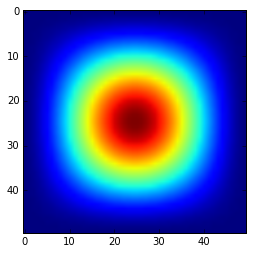

In [62]:
imshow(abs(twodrep(states[:,0]))**2)

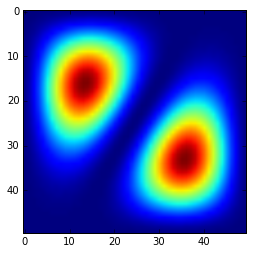

In [63]:
imshow(abs(twodrep(states[:,1]))**2)

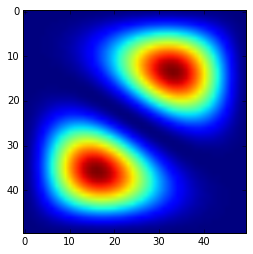

In [64]:
imshow(abs(twodrep(states[:,2]))**2)

These last two state are degenerate

In [65]:
print(energies[1],energies[2])

(23.690403977550595, 23.690403977550648)


Thus linear combinations are also eigenstates:

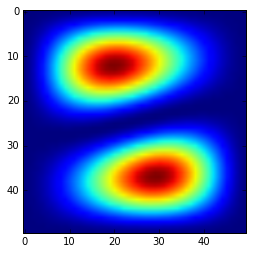

In [66]:
imshow(abs(twodrep(states[:,1]+states[:,2]))**2)

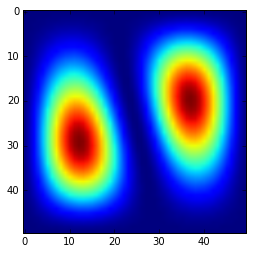

In [67]:
imshow(abs(twodrep(states[:,1]-states[:,2]))**2)

For fun, here is a higher mode

In [68]:
en,st=eigsh(boxham, k=1, sigma=520., return_eigenvectors=True)

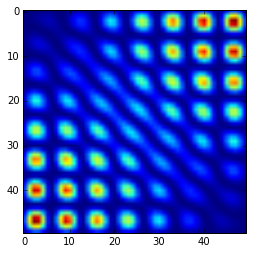

In [69]:
imshow(abs(twodrep(st[:,0]))**2)

## Potentials

Suppose we have a 2D potential on our grid.  For example, here is a 2D harmonic oscillator potential on a grid running from -2 to 2 in steps of 0.5

In [70]:
potvals=array([[(x**2+y**2)/2 for x in arange(-2,2,0.5)] 
               for y in arange(-2,2,0.5)])

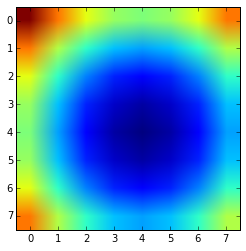

In [71]:
imshow(potvals)

To make the potential matrix we first "unwrap" this grid into a linear list of numbers.  First we need to know how many pixels we have.

In [72]:
numpixels=product(potvals.shape)
numpixels

64

We unwrap them via

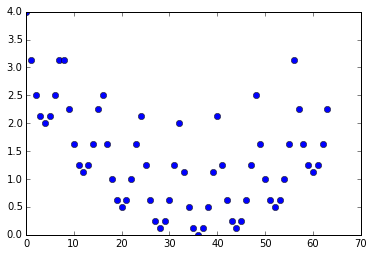

In [73]:
unwrapped=potvals.reshape(numpixels)
plot(unwrapped,"o")

Our potential matrix will be a 64x64 matrix that when applied to the 64 values of psi, multiplies each of them by $V$ at that site

In [74]:
potmat=dia_matrix((unwrapped,0),shape=[numpixels,numpixels])

In [75]:
showmat(potmat.todense())

4,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,3.12,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,2.5,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,2.12,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,2.12,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,2.5,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,3.12,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,3.12,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,2.25,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,1.62,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


We can encapsulate this via

In [76]:
def makepotmat(potvals):
    numpixels=product(potvals.shape)
    unwrapped=potvals.reshape(numpixels)
    return dia_matrix((unwrapped,0),shape=[numpixels,numpixels])

## Problem

Numerically find the energies of the first 5 eigenstates of a 2D Harmonic Oscillator.  Use a 40x40 grid with $x$ running from -4 to 4 in steps of 0.2, and y running from -4 to 4 in steps of 0.2.  Use units where the mass, $\hbar$ and $\omega$ are all 1.  

In [81]:
potvals=array([[(x**2+y**2)/2 for x in arange(-4,4,0.2)] 
               for y in arange(-4,4,0.2)])
v=makepotmat(potvals)
harmham=csc_matrix(-0.5*makelaplacematrix(40,0.2))+v
energies,states=eigsh(harmham, k=5, sigma=0., return_eigenvectors=True)

In [82]:
energies

array([ 0.9974944 ,  1.99247857,  1.99247857,  2.9825156 ,  2.9825156 ])

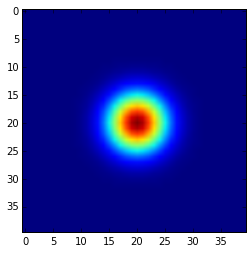

In [84]:
imshow(abs(twodrep(states[:,0]))**2)